In [2]:
import sys
sys.path.insert(0, './utils')

from parameters import *
import annexe
import optimization
import affichage

import matplotlib
import numpy as np
import math
import types
import matplotlib
import cvxpy as cp
import numpy as np

from numpy.random import rand, randn, randint
from numpy import sin, cos, tan, identity, ones, save, load, dot, diag
from scipy.spatial import distance_matrix
from numpy.linalg import svd, norm
from amplpy import AMPL
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

matplotlib.rcParams['animation.embed_limit'] = 2**128

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Méthode de base

### Génération de données

In [ ]:
# Parametres

# Malheureusement, dès qu'on dépasse 6 points pour mode polynomial ou 5 points pour
# mode périodique, notre temps de résoulution avec cette méthode devient conséquant

N = 6       # Nombre de sous-marins
d = 3       # Dimension
P = 3       # Degrée dans la trajectoire
end = -1    # 
taux = 1    # Taux de connexion
omega = 1   # Fréquence de la trajectoire périodique
start = 1   #
anchor = 4  # Nombre de points d'ancrage pour Procrustes

# Stockage des parametres.
param = parameters(N, d, P, omega, start, end, taux, anchor)

# Définition de mode de la trajectoire.
param.define_mode('polynomial')

In [ ]:
# Génération d'une trajectoire, des points.
A = annexe.generate_A(param)
realX = annexe.generate_trajectory(param, A)
realD = annexe.distance_trajectory(realX   )

# Affichage des trajectoires.
affichage.affichage([realX], param)

### Algorithme

In [3]:
# Définition des horizons
T, N, K = realX.shape

In [4]:
# Calcul de la distance entre les vecteurs.
d = rand(T, N, N)
for t in range(T):
    d[t] = distance_matrix(realX[t], realX[t])
    
# Calcul de la vitesse d'un sous-marins à tout intervalle du temps.
v = rand(T-1, N)
for t in range(T-1):
    for i in range(N):
        v[t, i] = norm(realX[t, i] - realX[t+1, i])

In [5]:
# Sauvegarde des données dans un fichier .dat
file = open("ampl/dgp-python.dat", "w")
file.write("# FILE GENERATED BY python-abdellah \n")

file.write("param n := {0};\n".format(N))
file.write("param k := {0};\n".format(K))
file.write("param time := {0};\n".format(T))

file.write("param d :=")
for t in range(T):
    for i in range(N):
        for j in range(N):
            file.write(" {0} {1} {2} {3}".format(t+1, i+1, j+1,  d[t, i, j]))
file.write(";\n")  

file.write("param vit :=")
for t in range(T-1):
    for i in range(N):
        file.write(" {0} {1} {2}".format(t+1, i+1,  v[t, i]))
file.write(";\n")  

file.close()

In [24]:
# AMPL pour résoudre le problème stocké en dgp.mod

lp = AMPL()
lp.read("ampl/dgp.mod")
lp.readData("ampl/dgp-python.dat")
lp.setOption("solver"  , "baron")
lp.solve()

ndata = lp.getData("n")
N = int(ndata.getRowByIndex(0)[0])
kdata = lp.getData("k")
K = int(kdata.getRowByIndex(0)[0])
tdata = lp.getData("time")
T = int(tdata.getRowByIndex(0)[0])
ddata = lp.getData("d")

solveres = lp.getData("solve_result")
solve_result = solveres.getRowByIndex(0)[0]
objfun = lp.getObjective("f")
objfunval = objfun.value()
xvar = lp.getVariable("x")
x_computed = rand(T, N, K)

for i in range(N):
    for j in range(K):
        for t in range(T):
            x_computed[t, i, j] = xvar[t+1, i+1, j+1].value()
    
print("solution norm is", np.linalg.norm(x_computed))
print("optimal objective function value is", objfunval)
print("solver status is", solve_result)

BARON 21.1.13 (2021.01.13): 0 iterations, optimal within tolerances.
Objective 905.0998814
solution norm is 12.282099992710721
optimal objective function value is 905.0998813856677
solver status is solved


In [28]:
# Matrice de Gram
Gb = rand(T, N, N)
for t in range(T):
    Gb[t] = x_computed[t]@x_computed[t].T
Gb.shape

(7, 6, 6)

(7, 6, 3)
7 6 3
La méthode de base:  2.0756413769096895e-06


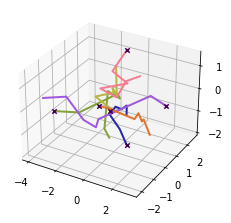

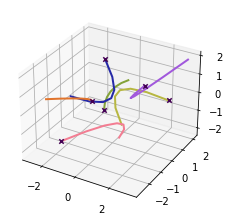

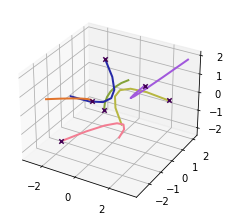

In [29]:
# La reconstruction
xb, xb_aligned, xb_fin, eb = optimization.reconstruction(Gb, realX, param)
affichage.affichage([xb, xb_fin, xb_aligned], param)
print("La méthode de base: ", eb)

## Méthode KEDM

### Génération de données

In [7]:
# Parametres

# Ici contrairement à la première méthode, on dépasse 20 points facilement

N = 20       # Nombre de sous-marins
d = 3       # Dimension
P = 3       # Degrée dans la trajectoire
end = -1    # 
taux = 1    # Taux de connexion
omega = 1   # Fréquence de la trajectoire périodique
start = 1   #
anchor = 4  # Nombre de points d'ancrage pour Procrustes

# Stockage des parametres.
param = parameters(N, d, P, omega, start, end, taux, anchor)

# Définition de mode de la trajectoire.
param.define_mode('polynomial')

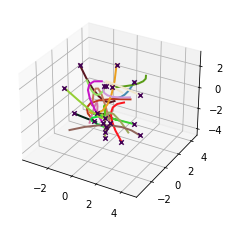

In [8]:
# Génération d'une trajectoire, des points.
A = annexe.generate_A(param)
realX = annexe.generate_trajectory(param, A)
realD = annexe.distance_trajectory(realX   )

# Affichage des trajectoires.
affichage.affichage([realX], param)

### Algorithme

In [9]:
# Résoulution avec KEDM

Gk = optimization.optim_kdm(realD, param)

(7, 20, 20)
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 15 11:07:22 AM: Your problem has 2800 variables, 14 constraints, and 0 parameters.
(CVXPY) Mar 15 11:07:22 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 11:07:22 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 11:07:22 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 11:07:22 AM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 11:07:22 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMat

(7, 20, 3)
7 20 3
La méthode KEDM:  8.82900622186075e-06


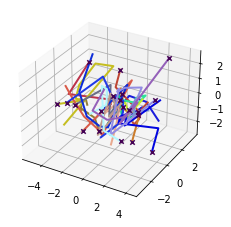

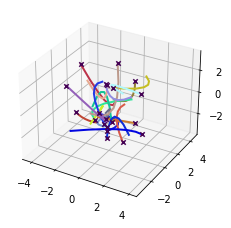

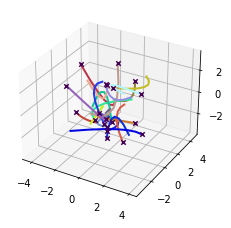

In [10]:
# La reconstruction
xk, xk_aligned, xk_fin, ek = optimization.reconstruction(Gk, realX, param)
affichage.affichage([xk, xk_fin, xk_aligned], param)
print("La méthode KEDM: ", ek)